# Tacotron Training Notebook **(WIP)**

Last edit: August 20th, 2020, 8:49 PM

This is the Notebook for training new Tacotron models.




If you're looking for the Glow-TTS notebooks, I haven't made them yet. I'll probably make the synthesis notebook sometime soon, but when/if I ever get it working again, I'll also put the training notebook here.

Tacotron2 by NVIDIA

https://github.com/NVIDIA/tacotron2

Notebook plagarized from Cookie's Notebook (sorry Cookie)

First, go up to "Files", and click "Save copy to Drive", and go to the copy, then continue.

# Check GPU

First, if you want, you can check to see which GPU is currently being used. The best GPUs are P100, V100, and T4. If you get a K80 or P4, you can restart the runtime and try again if you'd like, but all GPUs will (probably) work with this notebook.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-31f5a0df-adde-2128-e24e-a98400b14bd6)


#Mount Your Google Drive

You will need to mount your Google Drive for this notebook. This is where your models are saved. If you're planning on making a lot of Tacotron models, I would reccommend you get more Google Drive storage. Each model is 300 MB.

This cell will put a link to the Google Drive website, and it will ask you if you want to link your Google Drive. Afterwards, it will give you a code. Copy and paste it into the text box below the output.

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


# Donwload Tacotron

In [ ]:
%tensorflow_version 1.x
import os
!git clone -q https://github.com/NVIDIA/tacotron2
os.chdir('tacotron2')
!git submodule init
!git submodule update
!pip install -q unidecode tensorboardX

TensorFlow 1.x selected.
Submodule 'waveglow' (https://github.com/NVIDIA/waveglow) registered for path 'waveglow'
Cloning into '/content/tacotron2/waveglow'...
Submodule path 'waveglow': checked out '5bc2a53e20b3b533362f974cfa1ea0267ae1c2b1'
     |████████████████████████████████| 241 kB 4.3 MB/s 
     |████████████████████████████████| 124 kB 43.7 MB/s 


# Upload dataset

This is where you will need to upload your dataset. First, run the cell below. This will make the folder where you will put your audio files.

In [ ]:
data_path = 'wavs'
!mkdir {data_path}

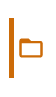

Next, go to the left of the screen, and click on the folder icon.

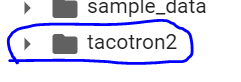

Then, click on the Tacotron folder

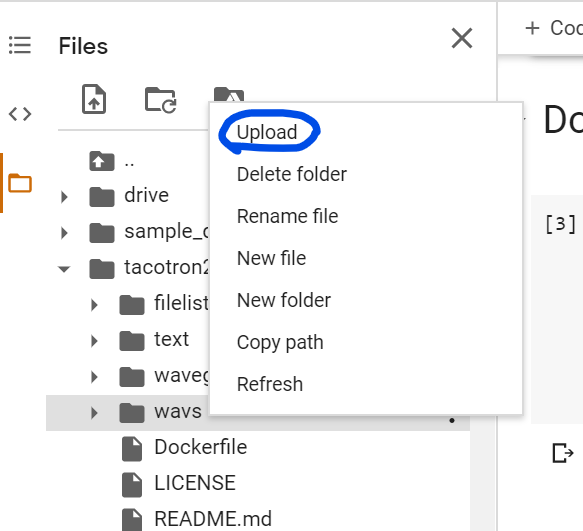

Right click on the "wavs" folder, and click upload. Then, upload of the wav files that you want to put in.

Right click on the "filelists" folder, and upload your text file.

# Prepare the model

This next section prepares the model and stuff for training.


In [ ]:
#@title A bunch of boring code and stuff (if you want to look at it, double click on this cell)
%matplotlib inline
import os
if os.getcwd() != '/content/tacotron2':
    os.chdir('tacotron2')
import time
import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams

import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
#from tqdm import tqdm # Terminal
#from tqdm import tqdm_notebook as tqdm # Legacy Notebook TQDM
from tqdm.notebook import tqdm # Modern Notebook TQDM
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename,
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))
    try:
        torch.save({'iteration': iteration,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)
    except KeyboardInterrupt:
        print("interrupt received while saving, waiting for save to complete.")
        torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
    print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2):
    """Training and validation logging results to tensorboard and stdout

    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      os.path.isfile("pretrained_model")
      download_from_google_drive("1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA","pretrained_model")
      model = warm_start_model("pretrained_model", model, hparams.ignore_layers)
      # download LJSpeech pretrained model if no checkpoint already exists

    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter() # eposh is russian, not a typo
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
# ---- Replace .wav with .npy in filelists ----

warm_start=False#sorry bout that
n_gpus=1
rank=0
group_name=None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
hparams = create_hparams()
model_filename = 'current_model'
hparams.training_files = "filelists/clipper_train_filelist.txt"
hparams.validation_files = "filelists/clipper_val_filelist.txt"
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 32
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 10000
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/My Drive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/tacotron2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



This is where you put the name of the model (usually the name of the person's voice you're cloning)

In [ ]:
#@title Name the model

model_filename = "Heaven" #@param {type:"string"}

Replace "PUTFILENAMEHERE" with the name of your text file.

In [ ]:
hparams.training_files = "filelists/Nepali.txt"
hparams.validation_files = "filelists/Nepali.txt"

### Set the parameters

You can play around with these if you want.

In [ ]:
# hparams to Tune

#These two are the most important
hparams.batch_size = 10 # Controls how fast the model trains. Don't set this too high, or else it will GPU will OOM (out of memory). 30-ish is usually a good number if you have a bigger dataset. If the number of audio files is more than/about the same as this number, it won't train properly, and you won't be able to use it.
hparams.epochs = 50 # Maxmimum epochs (number of times the AI looks through the dataset) to train

#The rest aren't that important
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000         # wait till decay_start to start decaying learning rate
hparams.A_ = 5e-4                   # Start/Max Learning Rate
hparams.B_ = 8000                   # Decay Rate
hparams.C_ = 0                      # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-5    # Min Learning Rate
generate_mels = True # Don't change
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.load_mel_from_disk = True
hparams.ignore_layers = [] # Layers to reset (None by default, other than foreign languages this param can be ignored)

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/My Drive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/tacotron2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

### Create MEL spectrograms

The MEL spectrograms are the input for the AI.

In [ ]:
if generate_mels:
    create_mels()

Generating Mels


  0%|          | 0/38 [00:00<?, ?it/s]

### Check data

This cell will go through the dataset one more time to see if anything's wrong before training starts.

In [ ]:
check_dataset(hparams)

Checking Training Files
Checking Validation Files
Finished Checking


# Start training!

This next cell will begin training the model!

FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    616      0 --:--:-- --:--:-- --:--:--   615
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  107M    0  107M    0     0  37.9M      0 --:--:--  0:00:02 --:--:-- 86.6M
Warm starting model from checkpoint 'pretrained_model'


  0%|          | 0/50 [00:00<?, ?it/s]


Starting Epoch: 0 Iteration: 0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 Validation loss 3:  1.430377  Time: 0.1m LR: 0.000500


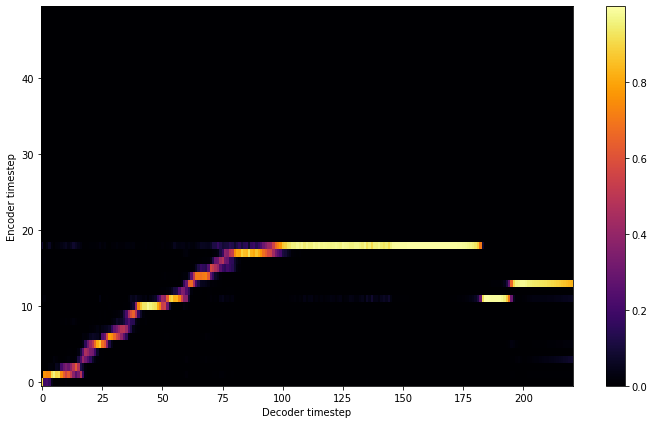

Saving model and optimizer state at iteration 3 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 1 Iteration: 3


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 Validation loss 6:  0.544899  Time: 0.1m LR: 0.000500


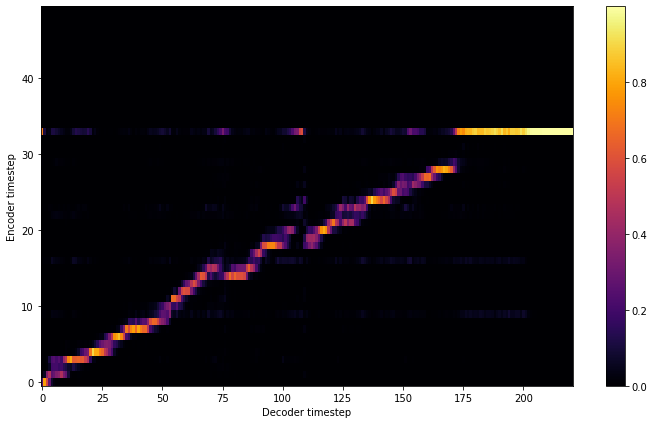

Saving model and optimizer state at iteration 6 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 2 Iteration: 6


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2 Validation loss 9:  0.472450  Time: 0.1m LR: 0.000500


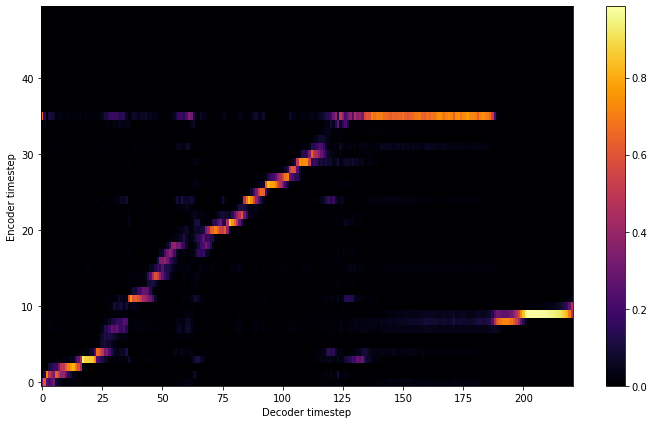

Saving model and optimizer state at iteration 9 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 3 Iteration: 9


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 Validation loss 12:  0.389530  Time: 0.1m LR: 0.000500


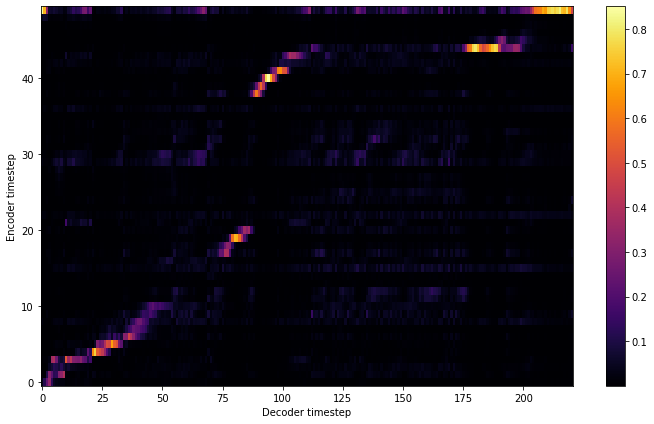

Saving model and optimizer state at iteration 12 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 4 Iteration: 12


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4 Validation loss 15:  0.371958  Time: 0.1m LR: 0.000500


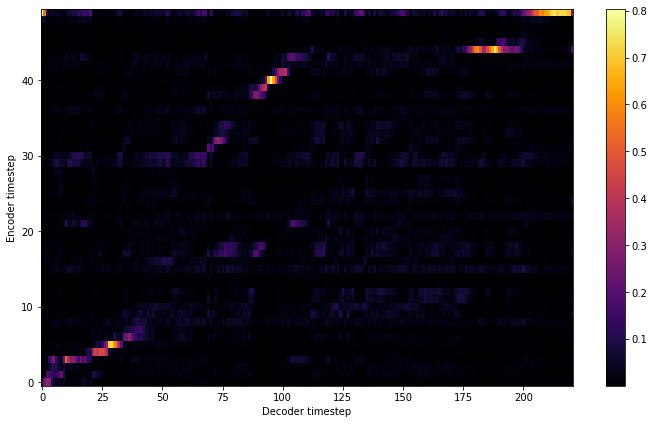

Saving model and optimizer state at iteration 15 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 5 Iteration: 15


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 Validation loss 18:  0.357494  Time: 0.1m LR: 0.000500


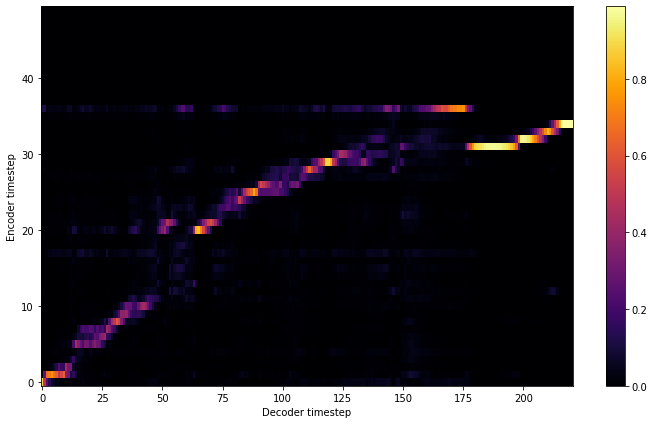

Saving model and optimizer state at iteration 18 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 6 Iteration: 18


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 Validation loss 21:  0.353007  Time: 0.1m LR: 0.000500


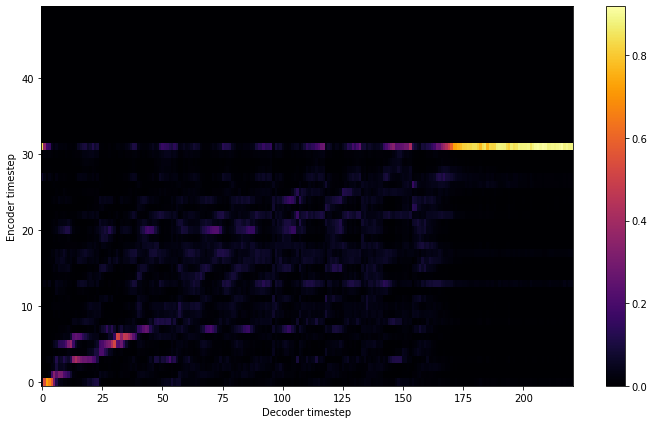

Saving model and optimizer state at iteration 21 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 7 Iteration: 21


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 Validation loss 24:  0.353605  Time: 0.1m LR: 0.000500


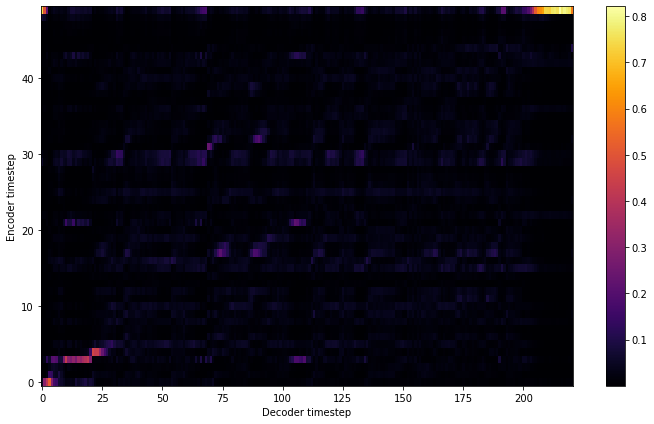

Saving model and optimizer state at iteration 24 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 8 Iteration: 24


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 Validation loss 27:  0.389180  Time: 0.1m LR: 0.000500


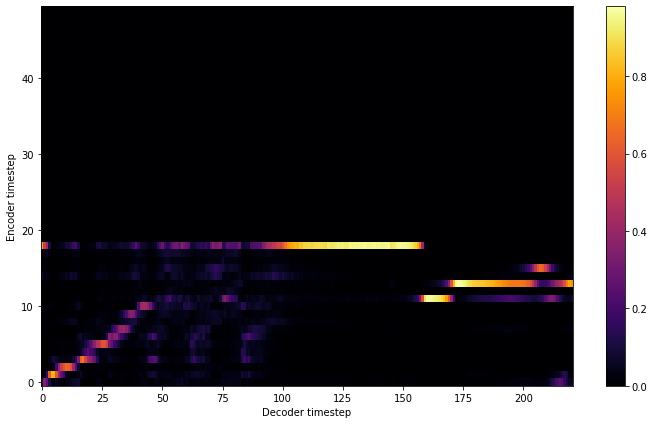

Saving model and optimizer state at iteration 27 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 9 Iteration: 27


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 Validation loss 30:  0.324575  Time: 0.1m LR: 0.000500


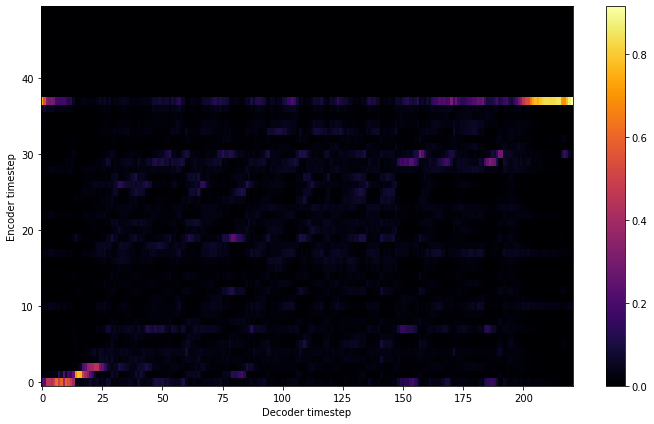

Saving model and optimizer state at iteration 30 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 10 Iteration: 30


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 Validation loss 33:  0.311723  Time: 0.1m LR: 0.000500


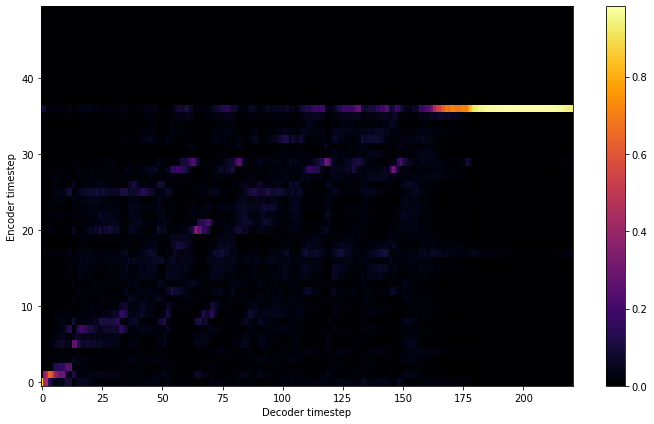

Saving model and optimizer state at iteration 33 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 11 Iteration: 33


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 Validation loss 36:  0.298389  Time: 0.1m LR: 0.000500


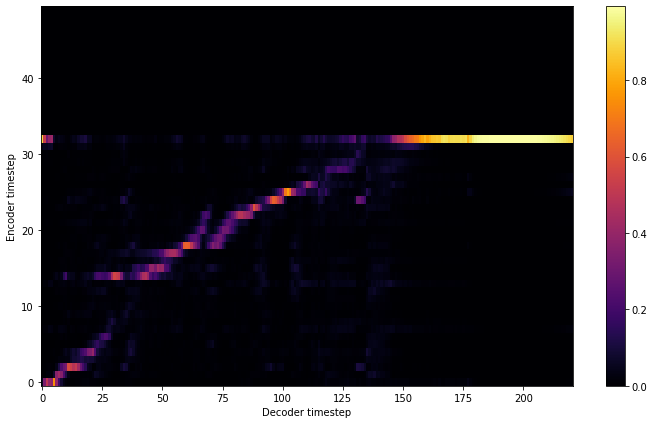

Saving model and optimizer state at iteration 36 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 12 Iteration: 36


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 Validation loss 39:  0.288312  Time: 0.1m LR: 0.000500


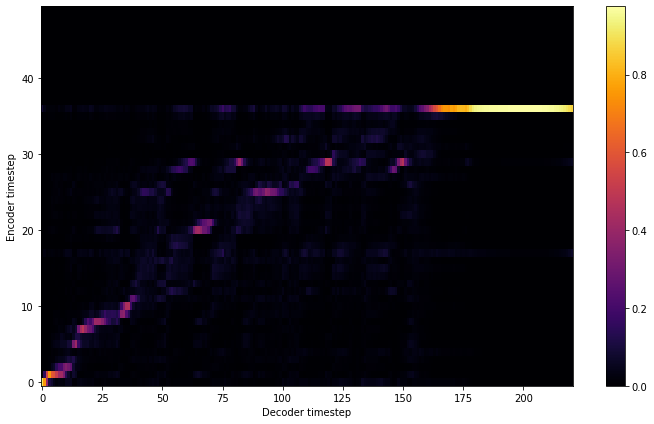

Saving model and optimizer state at iteration 39 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 13 Iteration: 39


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 Validation loss 42:  0.304435  Time: 0.1m LR: 0.000500


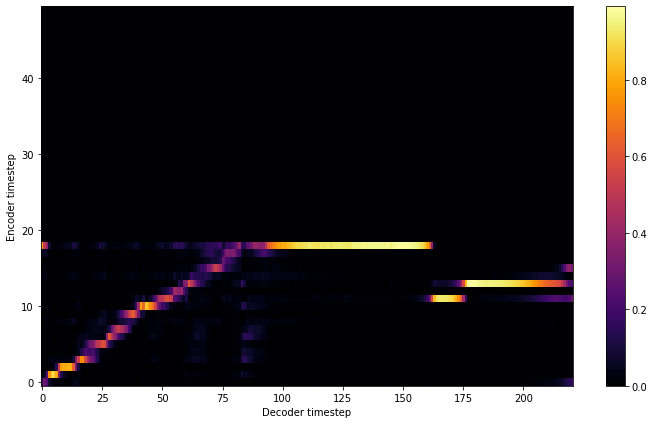

Saving model and optimizer state at iteration 42 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 14 Iteration: 42


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 Validation loss 45:  0.280366  Time: 0.1m LR: 0.000500


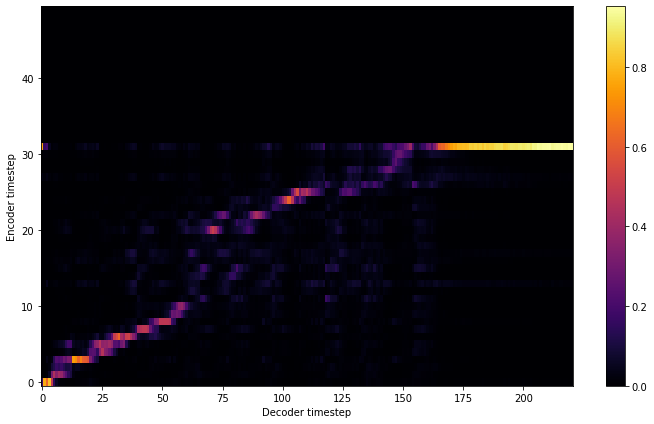

Saving model and optimizer state at iteration 45 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 15 Iteration: 45


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 Validation loss 48:  0.291152  Time: 0.1m LR: 0.000500


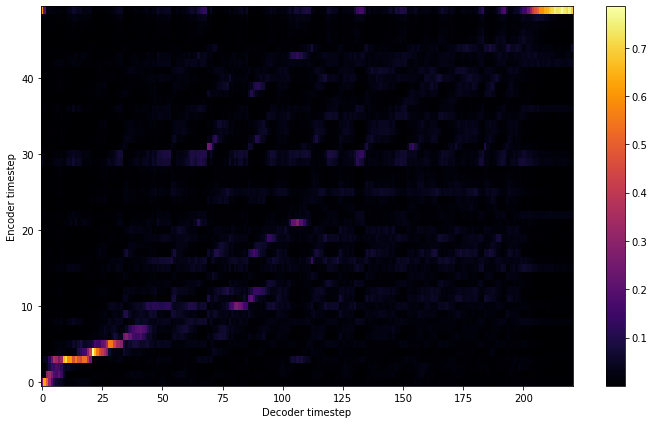

Saving model and optimizer state at iteration 48 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 16 Iteration: 48


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 Validation loss 51:  0.274881  Time: 0.1m LR: 0.000500


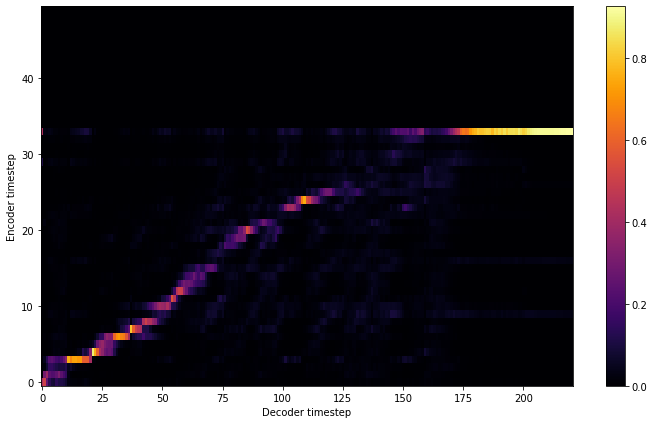

Saving model and optimizer state at iteration 51 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 17 Iteration: 51


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 Validation loss 54:  0.274755  Time: 0.1m LR: 0.000500


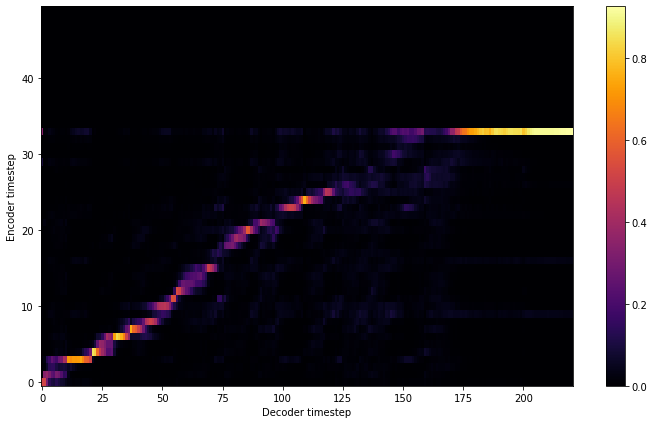

Saving model and optimizer state at iteration 54 to /content/drive/My Drive/colab/outdir/Heaven
Model Saved

Starting Epoch: 18 Iteration: 54


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)
train(output_directory, log_directory, checkpoint_path,
      warm_start, n_gpus, rank, group_name, hparams, log_directory2)

Congrats! You've (hopefully) successfully trained a Tacotron model!

If there was a problem with training, just leave a comment on the YouTube video, and I'll try to respond!

Now, before you go into the synthesis notebook, go to your Google Drive, (https://drive.google.com/drive/my-drive), go into the folder that says "colab", go into "outdir", and right click on the .tar file with your model's name.
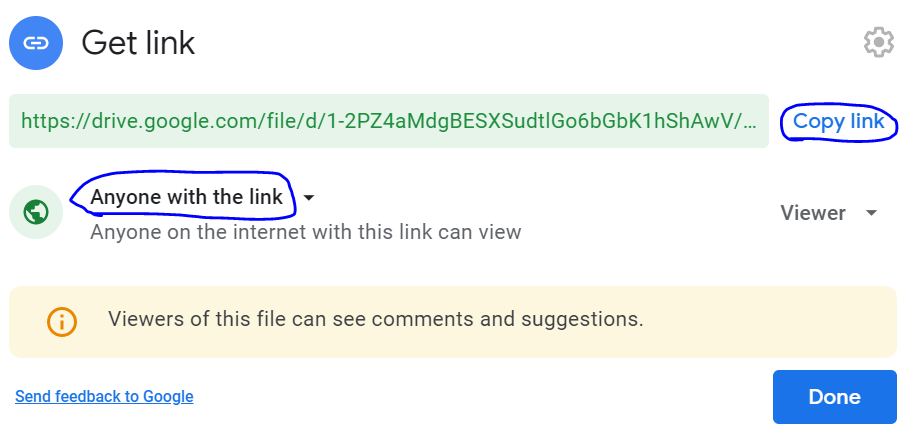
Click on "get shareable link", change "Restricted" to "anyone with the link", then copy the link!